<a href="https://colab.research.google.com/github/glingden/Natural-Language-Processing-NLP/blob/master/ELMo_Semantic_Text_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELMo Semantic Text Similarity
In this notebook, the ELMo (original) model is used for finding  semantic text similarity between a pair of sentences.  The [STS_B benchmark](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset is used for this work. This dataset consists of separate training, validation and test data. The [allenlp framework](https://github.com/allenai/allennlp) is used to carry out the work. The work in this notebook contains two parts:
1. Sentence level embedding extraction from the pre-trained  model and apply cosine similarity between the pair sentences (No fine-tunned, but only using sentence vector representation from the pretrained model)

2. Fine-tune: The STS_B train dataset is used for fine tunning the model and validation dataset is used for model validation. And, the fine-tunned model is used to predict the test dataset. For fine-tunning, Siamese Network with cosine similarity output is used.

In [1]:
#import necessary dependencies
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # minmax scaling
from scipy.spatial.distance import cosine #cosine distance
from scipy.stats import pearsonr # pearson correlation
from scipy.stats import spearmanr # spearman correlation
from collections import defaultdict, Counter #store scores
import torch
import torch.nn as nn
from typing import Dict, Iterable, List, Union #for arugument types



GPU from Google Colab is used in this work. So, check if GPU is avaiable, and if not rasie error. We have to identify and specify GPU as device use it. 

In [2]:
#check GPU is available or not 
if torch.cuda.is_available():

  device = torch.device("cuda")
  current_dev = torch.cuda.current_device()
  print('Found GPU :', torch.cuda.get_device_name(0))
  print(current_dev)
  

else:
    print('Not found, use CPU instead')
    device = torch.device("cpu")
  


Found GPU : Tesla K80
0


#Load Dataset
Dataset is stored at Google drive. So, google drive is mounted at '/content/drive' to access them.

In [3]:
#mount the drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#load dataset
dataset_types = [ "sts-train.csv", "sts-dev.csv", "sts-test.csv",] # 3 datasets
col_names = ["genre", "file", "years", "_", "score(0-5)", "sentence_1", "sentence_2"] #columns names

#collect as a list of pandas dataframes
df_list = []
for dataset in dataset_types:
  df = pd.read_csv("/content/drive/My Drive/Google_Colab/stsbenchmark_dataset/"+ dataset, 
                 delimiter=',' , 
                 header= None,
                 names= col_names
                )
  

  df_list.append(df)

In [5]:
#separate dataset (train, dev and test)
df_train = df_list[0]
df_dev = df_list[1]
df_test = df_list[2]
df_train.sample(5)

,genre,file,years,_,score(0-5),sentence_1,sentence_2
392,main-captions,MSRvid,2012test,594,3.0,A person is adding food in a pan.,A woman puts rice into a pan.
3685,main-news,deft-news,2014,235,3.2,the north korean government has warned the sou...,the north korean government stated if the sout...
5503,main-news,headlines,2015,1388,5.0,US believes Syrian government used chemical we...,US suspects Syria used chemical weapons
1280,main-captions,images,2014,410,3.4,a man on a dirt bike jumping very high.,A man on a motorbike jumping with the sky behi...
2238,main-forum,deft-forum,2014,238,2.8,My parents have told me it is bad for you.,My Sheriff has told me its bad for you.


In [6]:
#install allen nlp
!pip install allennlp

In [7]:
#allennlp libraries
from overrides import overrides
from allennlp.data import DatasetReader, Instance, DataLoader, Vocabulary
from allennlp.data.fields import  TextField, ArrayField
from allennlp.data.fields.text_field import TextFieldTensors
from allennlp.data.tokenizers import Tokenizer, SpacyTokenizer, WhitespaceTokenizer
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.samplers import BasicBatchSampler, BucketBatchSampler, RandomSampler
from allennlp.modules import Seq2VecEncoder
from allennlp.training.metrics import PearsonCorrelation
from allennlp.training.util import evaluate 
from allennlp.nn.util import get_text_field_mask, move_to_device
from allennlp.nn import util
from allennlp.models import Model
from allennlp.predictors import Predictor

#elmo module
from allennlp.modules.elmo import Elmo, batch_to_ids 
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import ElmoTokenEmbedder
from allennlp.data.token_indexers.elmo_indexer import ELMoTokenCharactersIndexer

#Count tokens in Sequences
Since we have to have equal length of every sequence in a batch, check the maximun token length in every sentences in all datasets. We will use this max length while preparing dataset. More details in 'Prepare dataset' section.

Or, we may use the other best max-length. So that there is no risk of loss of much tokens while doing truncating and not require  much padding in the sequences.

In [9]:
#counts tokens in sequences
dataset_all = [df_train.sentence_1, df_train.sentence_2, df_dev.sentence_1, df_dev.sentence_2,df_test.sentence_1,df_test.sentence_2] #list of all dataset
dataset_type_name = ['df_train.sentence_1', 'df_train.sentence_2', 'df_dev.sentence_1', 'df_dev.sentence_2', 'df_test.sentence_1', 'df_test.sentence_2'] #name of dataset

max_len = 0 # tokens max count in overall datasets
token_len_list = [] #store token counts for each dataset
higest_token_len = {} # store higest token counts in each dataset


#zip and iterate over all datasets
for nam_data, each_dataset in zip(dataset_type_name, dataset_all):
  token_len_dataset = [] #store each sequence count of each dataset
  max_len_seq= 0 # max count of  sequence in each dataset 

  #iterate over sequences in each dataset
  for sent in each_dataset:
    tokenizer = SpacyTokenizer()# tokenizer
    #tokenizer = WhitespaceTokenizer()# tokenizer
    tokens = tokenizer.tokenize(sent) #tokenize
    tokens_len = len(tokens) # count length
    token_len_dataset.append(tokens_len) 
    
    
    # keep tracking the higest counts in each dataset
    if tokens_len > max_len_seq:
      max_len_seq = tokens_len
    
    #higest count overall dataset
    if max_len_seq > max_len:
      max_len = max_len_seq
       
  higest_token_len[nam_data] =  max_len_seq 
  token_len_list.append(token_len_dataset)

print("Higest tokens number among 3 datasets: %s ." % (max_len))
print()
print('Higest counts in each dataset:\n')
higest_token_len


Higest tokens number among 3 datasets: 137 .

Higest counts in each dataset:



{'df_dev.sentence_1': 39,
 'df_dev.sentence_2': 37,
 'df_test.sentence_1': 37,
 'df_test.sentence_2': 34,
 'df_train.sentence_1': 135,
 'df_train.sentence_2': 137}

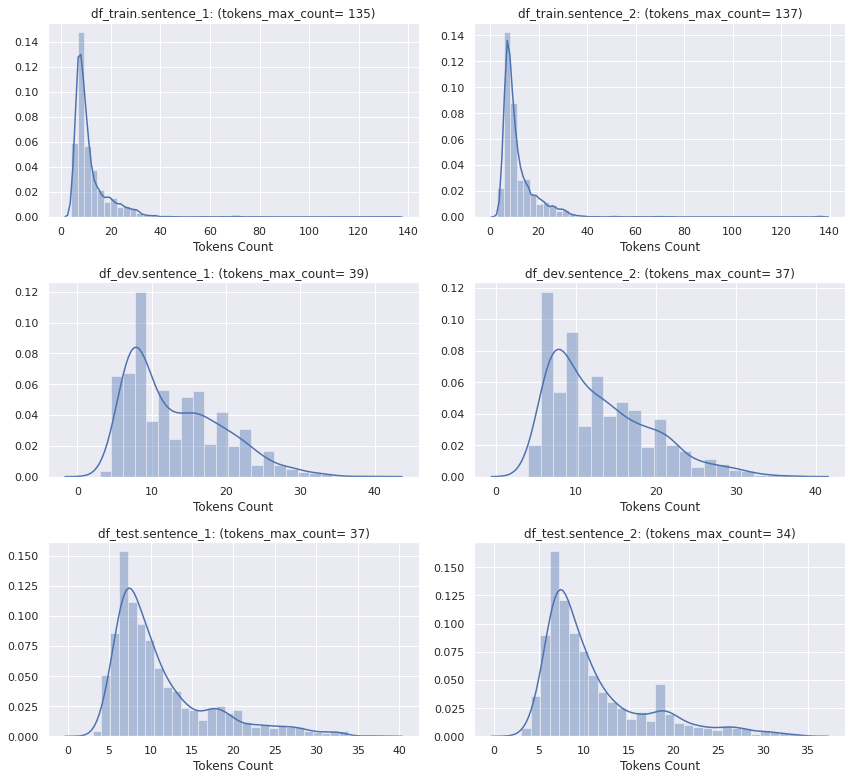

In [11]:
#Plot the diagram to show the tokens' length distribution in dataset
import seaborn as sns
from matplotlib import pyplot as plt

# data to plot
data = token_len_list 

#creates subplots  with nrows=3, ncols=2
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,11))
sns.set(style='darkgrid') #set plot style

#change 'axes' to 1d, zip and emumerate
for i, (name, axe)  in enumerate(zip(dataset_type_name, axes.flatten())):
  sns.distplot(token_len_list[i], axlabel ='Tokens Count', ax=axe) #distplot type
  name = name + ': (tokens_max_count= '+ str(higest_token_len[name]) + ')' #title (for example: df_train.sentence_1:(max_count=70))
  axe.set_title(name) #title for each suplots
fig.tight_layout()#fit nicely
plt.show()


#Prepare Dataset
Allennlp frame requires their own type of dataset object  while modeling the algorithms. So, 
we prepare as per the requirement of it.

In [9]:
#dataset reader class
class SemanticTextDataReader(DatasetReader):
  '''' Read the dataset and return allennlp instance of  each data '''
  def __init__(self, 
               lazy: bool = False, 
               tokenizer = None, 
               token_indexers: Dict[str, TokenIndexer] = None, 
               max_tokens: int = None
               ):
    super().__init__(lazy)
    self.tokenizer = tokenizer or WhitespaceTokenizer() #tokenizer
    self.token_indexers = token_indexers or {'tokens': SingleIdTokenIndexer()} #token indexer
    self.max_tokens = max_tokens #set max_tokens for padding or truncating
    

  #convert given text into instance
  @overrides
  def text_to_instance(self, sent_1: str, sent_2: str, gold_score: float = None) -> Instance:
    ''' Return given sequence into allennlp Instance '''
    
    #tokenize text
    token_1 = self.tokenizer.tokenize(sent_1) #first sent
    token_2 = self.tokenizer.tokenize(sent_2) #second sent
    
    #tokens upto max token-size
    if self.max_tokens:
            token_1 = token_1[:self.max_tokens]
            token_2 = token_2[:self.max_tokens]
    
    #Textfield
    text_field_1 = TextField(token_1, self.token_indexers) 
    text_field_2 = TextField(token_2, self.token_indexers)

    #fields contain 'Textfield' and 'LabelField'
    fields = {'first_sent': text_field_1, 'second_sent': text_field_2 } 
    
    #check score/label is given or not
    if gold_score is not None:
      fields['score'] = ArrayField(np.array([gold_score])) # labelfield
   
    return Instance(fields) #instance with inputs and outputs fields 

    
  #Read dataset and convert them to Iterable Instance
  @overrides
  def _read(self, file_path: str) -> Iterable[Instance]:
    ''' Read dataset and process them '''
    
    #read data with pandas
    df = pd.read_csv(file_path, 
              delimiter=',' , 
              header= None,
              names= col_names
              )
    
    #scale down gold-score(0-5) to (0-1) since cosine-simialrity score(0-1)
    df['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df[['score(0-5)']])
    print('Data reading started .....')
    
    
    #iterate over rows in df
    for index, row in df.iterrows():
      sent_1 = row['sentence_1']#first sent
      sent_2 = row['sentence_2']#second sent
      gold_score = row['scaled_score(0-1)']#score
      yield self.text_to_instance(sent_1, sent_2, gold_score) #iterable

    print('...... Completed.')
    print()
  
    

In [10]:
#Read dataset
file_path = "/content/drive/My Drive/Google_Colab/stsbenchmark_dataset/" #file path
dataset_types = [ "sts-train.csv", "sts-dev.csv", "sts-test.csv",] # 3 datasets
col_names = ["genre", "file", "years", "_", "score(0-5)", "sentence_1", "sentence_2"] #columns names
max_tokens = [137, 39, 37] #max-tokens for each dataset

text_tokenizer = SpacyTokenizer() #tokenizer
elmo_indexer = ELMoTokenCharactersIndexer() #Elmocharacter Indexer

dataset_instances = {}
#use max-token length based on data
for i ,x in enumerate(dataset_types):
  if x == dataset_types[i]:
    max_token = max_tokens[i]
    dataset_reader = SemanticTextDataReader(tokenizer= text_tokenizer,  token_indexers={'elmo_tokens': elmo_indexer}, max_tokens=max_token) #initia datareader
    instances = dataset_reader.read(os.path.join(file_path, dataset_types[i]))
    dataset_instances[x]  = instances
  


269it [00:00, 1081.75it/s]

Data reading started .....


5749it [00:04, 1239.80it/s]
164it [00:00, 1639.57it/s]

...... Completed.

Data reading started .....


1500it [00:01, 1092.83it/s]
189it [00:00, 1886.61it/s]

...... Completed.

Data reading started .....


1379it [00:00, 1517.36it/s]

...... Completed.



In [11]:
#check the dataset instances
for x in dataset_instances['sts-train.csv']:
  print(x)
  break

Instance with fields:
 	 first_sent: TextField of length 6 with text: 
 		[A, plane, is, taking, off, .]
 		and TokenIndexers : {'elmo_tokens': 'ELMoTokenCharactersIndexer'} 
 	 second_sent: TextField of length 7 with text: 
 		[An, air, plane, is, taking, off, .]
 		and TokenIndexers : {'elmo_tokens': 'ELMoTokenCharactersIndexer'} 
 	 score: ArrayField with shape: (1,) and dtype: <class 'numpy.float32'>. 



#Prepare Vocabulary and DataLoader
Eventhough we don't have to make new vocabulary here, we have to create vocab object and have to do indexing to all the dataset instances. So, each token/character get certain index(integer value) according to ELMO pretrained model.

In [12]:
 
vocab = Vocabulary() #initiate vocabulary 
dataset_instances['sts-train.csv'].index_with(vocab) #token indexing 
dataset_instances['sts-dev.csv'].index_with(vocab)
dataset_instances['sts-test.csv'].index_with(vocab)

#random sample and batch train data
sampler_tr = RandomSampler(data_source=dataset_instances['sts-train.csv']) 
batch_sampler_tr = BasicBatchSampler(sampler_tr, batch_size=32, drop_last=False) 
train_data_loader = DataLoader(dataset_instances['sts-train.csv'], batch_sampler=batch_sampler_tr)

#batch dev data
dev_data_loader = DataLoader(dataset_instances['sts-dev.csv'], batch_size=32,)

#batch test data
test_data_loader = DataLoader(dataset_instances['sts-test.csv'], batch_size=32,) 



In [13]:
#check train dataloader 
batch = next(iter(train_data_loader))
batch

{'first_sent': {'elmo_tokens': {'elmo_tokens': tensor([[[259,  83, 102,  ..., 261, 261, 261],
            [259, 106, 111,  ..., 261, 261, 261],
            [259,  67, 112,  ..., 261, 261, 261],
            ...,
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,   0]],
   
           [[259,  66, 260,  ..., 261, 261, 261],
            [259, 120, 112,  ..., 261, 261, 261],
            [259, 106, 116,  ..., 261, 261, 261],
            ...,
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,   0]],
   
           [[259,  85, 105,  ..., 261, 261, 261],
            [259,  52,  49,  ..., 261, 261, 261],
            [259,  99, 112,  ..., 261, 261, 261],
            ...,
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,   0],
            [  0,   0,   0,  ...,   0,   0,  

# ElMo CharacterTokenizer

In ELMo, as like other  pretained model, the sequence is tokenized. And, the tokenized token is further splited into characters  with of 50 dimensions.

In [14]:
#a single batch contains collection of tokens and  single token is ocnverted into array of  character ids of 50 size
print('Batch shape :', batch['first_sent']['elmo_tokens']['elmo_tokens'].shape) #(batch size, token length, char dim)
print()
print('tokens in a sequence: ')
batch['first_sent']['elmo_tokens']['elmo_tokens'][0]

Batch shape : torch.Size([32, 30, 50])

tokens in a sequence: 


tensor([[259, 117, 105,  ..., 261, 261, 261],
        [259, 118, 111,  ..., 261, 261, 261],
        [259, 116, 117,  ..., 261, 261, 261],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])

#Part-1 ELMo Embedding Extraction
Extract sentence level embedding is extracted with mean pooling over tokens in a sentence. The original elmo model is used  and the cosine similarity between a pair of sentence is calculated.  And, finally the pearson and spearman correlation score is computed between the gold-score and computed cosine similarity.



In [19]:
weight_file = 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5'
options_file = 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json'
 
#Two ways  ELMo representation can be computated in Allennlp
# 1. ElmoTokenEmbeder 
elmo_embedding = ElmoTokenEmbedder(options_file = options_file, weight_file = weight_file, requires_grad = False)
word_embedding = BasicTextFieldEmbedder({"elmo_tokens": elmo_embedding}) 

#2. direclty Elmo module
elmo_embedder = Elmo( options_file, 
                     weight_file,
                     num_output_representations =1,
                     requires_grad = False,
                     ) 

100%|██████████| 374434792/374434792 [00:08<00:00, 43413757.97B/s]


In [ ]:
#data loader
#extract embedding, calcuate pearson and spearman correlation
def batch_elmo_embedder(dataset: DataLoader, elmo_embedder: BasicTextFieldEmbedder, cos:nn.CosineSimilarity):
  pear_score_list = [] #pearson score
  sperman_score_list = [] # sperman score 
  '''
  elmo_embeded_1 = torch.tensor([]) #store embedding
  elmo_embeded_2 = torch.tensor([])
  gold_score = torch.tensor([])#gold score '''

  #iterate over each batchs
  for batch in dataset:
    
    #first sentence
    elmo_embeding_1 = elmo_embedder(batch['first_sent']['tokens']['elmo_tokens']) #return token embeding and mask
    token_level_embedding_1 = elmo_embeding_1['elmo_representations'][0] # token embedding
    sent_level_embedding_1 = token_level_embedding_1.mean(dim=1) # tokens mean pooling
    

    #second sentence
    elmo_embeding_2 = elmo_embedder(batch['second_sent']['tokens']['elmo_tokens']) #return token embeding and mask
    token_level_embedding_2 = elmo_embeding_2['elmo_representations'][0] # token embedding
    sent_level_embedding_2 = token_level_embedding_2.mean(dim=1) # tokens mean pooling
    
    #gold score
    score = batch['score']
    score = score.flatten() # 1d
    
    '''
    elmo_embeded_1 = torch.cat((elmo_embeded, sent_level_embedding_1,), dim= 0 ) #concat embdding
    elmo_embeded_2 = torch.cat((elmo_embeded, sent_level_embedding_1,), dim= 0 ) #concat embdding
    gold_score = torch.cat((gold_score, score), dim= 0 ) #concat embdding '''
    
    #calculate cosine similarity between a pair of sentences
    cosine_sim = cos(sent_level_embedding_1, sent_level_embedding_2)
    cosine_sim = cosine_sim.flatten().detach() #numpy
 
    #calcualte Pearson score
    person_score, _ = pearsonr(score, cosine_sim) 
    pear_score_list.append(person_score)
  
    #calcualte Spearman score
    sperman_score, _ = spearmanr(score, cosine_sim) 
    sperman_score_list.append(sperman_score)
  
  return np.mean(pear_score_list), np.mean(sperman_score_list)

    

In [ ]:
#compute pearsons and spearman
cos = cos = nn.CosineSimilarity(dim=1, eps=1e-6)
batch_elmo_embedder(test_data_loader, elmo_embedder, cos)

(0.42302950514719806, 0.39722409909301976)

In [ ]:
#extract elmo embedding from list of string
def elmo_feature_embedding(data: List[str], 
                           elmo_embedder: BasicTextFieldEmbedder,
                           tokenizer: Tokenizer, 
                           token_indexer: ELMoTokenCharactersIndexer, 
                           vocab: Vocabulary
                           ):
  '''
  Extract elmo embedding of given sequence.

    Args:
      data(list): list of strings/sequences
      elmo_embedder: allennlp elmo TextField embedder object
      tokenizer: allennlp SpacyTokenizer object
      token_indexer: allennlp ELMoTokenCharactersIndexer object
      vocab: allennlp vocabualry object

    Returns:
       Sentence embedding(2d) of 1024 dimensions
  
  '''

  #empty array to store elmo embedding vectors
  sent_embedded = np.empty((0, 1024)) # size(,1024) 
  
  #iterate over sequence 
  for sequence in data:
    tokens = tokenizer.tokenize(sequence) # tokenize sequence
    text_field = TextField(tokens, {'elmo_tokens': token_indexer}) #tokens to ELMoTokenCharactersIndexer
    text_field.index(vocab) #character_ids based on vocab
    padding_lengths = text_field.get_padding_lengths() # get tokens length
    tensor_dict = text_field.as_tensor(padding_lengths) #change to TextFieldTensors
    batch_tensor_dict = text_field.batch_tensors([tensor_dict]) # batch_tensor
    elmo_embedded = elmo_embedder(batch_tensor_dict)# get token embedding
    mean_tokens_embed = elmo_embedded.mean(dim=1)# mean pooling over tokens
    sent_embedded = np.append(sent_embedded, mean_tokens_embed.detach().numpy(), axis=0) # append vertically
    
  return sent_embedded
  


In [ ]:
#function to calculate similarity score 
def calc_similarity_score(embed_1, embed_2):

  """
  Calcualte cosine simialrity between a pair of sentences.
  
    Args:
      embed_1(numpy array): first sentence embedding
      embed_2(numpy array): second sentence embedding

    Return:
      scaled_cosine_score(list) : cosine score between embed_1 
      and embed_2 with range (0,5)
  """
  
  #collect similarity score
  cosine_sim_score = []
  
  for x,y in zip(embed_1, embed_2):

    distance = cosine(x, y) # cosine distance
    cosine_sim = 1 - distance # cosine similarity
    cosine_sim_score.append(cosine_sim) 

  


  #scaled the similarity score to (0,5)
  scaler = MinMaxScaler(feature_range=(0,5)) # initiate minmaxscaler
  scaled_cosine_score = scaler.fit_transform(np.transpose([cosine_sim_score])) #scaled to (0,5)
  
  return scaled_cosine_score.round(3)
  

In [54]:
#calculate pearson and spearman correlation
def cal_pearson_spearman_score(x, y):
  '''
  Calculate Pearson and Spearman correlation between x, y.
  Agrs:
    x: array_like
    y: array_like

  Returns:
    Pearson and Spearman score
  '''

  pearson_score, _ = pearsonr(x, y)#pearson score
  sperman_score, _ = spearmanr(x, y)#spearman score

  return pearson_score , sperman_score



In [ ]:
#initiate necessary class object
text_tokenizer = SpacyTokenizer() #tokenizer
elmo_indexer = ELMoTokenCharactersIndexer() #character Indexer
vocab = Vocabulary()# initiate vocab

elmo_token_embedder = ElmoTokenEmbedder(options_file, weight_file) #elmo token embedder
elmo_textfield_embedder = BasicTextFieldEmbedder({"elmo_tokens": elmo_token_embedder}) #textfield embedder

In [ ]:
%%time
#extract embedding
dev_first_sent_emlo_embeded = elmo_feature_embedding(df_dev.sentence_1.values.tolist(), elmo_textfield_embedder, text_tokenizer, elmo_indexer, vocab )
dev_second_sent_emlo_embeded = elmo_feature_embedding(df_dev.sentence_2.values.tolist(), elmo_textfield_embedder, text_tokenizer, elmo_indexer, vocab )
test_first_sent_emlo_embeded = elmo_feature_embedding(df_test.sentence_1.values.tolist(), elmo_textfield_embedder, text_tokenizer, elmo_indexer, vocab )
test_second_sent_emlo_embeded = elmo_feature_embedding(df_test.sentence_2.values.tolist(), elmo_textfield_embedder, text_tokenizer, elmo_indexer, vocab )

CPU times: user 46min 47s, sys: 2.57 s, total: 46min 50s
Wall time: 46min 54s


In [ ]:
#calcualte cosine similarity, pearson and spearman score
elmo_pear_spear_score = defaultdict(list) #store scores

dev_cos = calc_similarity_score(dev_first_sent_emlo_embeded, dev_second_sent_emlo_embeded).flatten()
dev_pear, dev_spear = cal_pearson_spearman_score(dev_cos, df_dev.loc[:,'score(0-5)'].values )
elmo_pear_spear_score['dev'].append(dev_pear)
elmo_pear_spear_score['dev'].append(dev_pear)
print('Dev data: Pearson score: {}, Spearman score: {}'.format(dev_pear,dev_spear))

test_cos = calc_similarity_score(test_first_sent_emlo_embeded, test_second_sent_emlo_embeded).flatten()
test_pear, test_spear = cal_pearson_spearman_score(test_cos, df_test.loc[:,'score(0-5)'].values )
print('Test data: Pearson score: {}, Spearman score: {}'.format(test_pear,test_spear))



Dev data: Pearson score: 0.6167761548996509, Spearman score: 0.6267256240989642
Test data: Pearson score: 0.4737381895764178, Spearman score: 0.4499075352319293


In [ ]:
#show in panda dataframe
pd.DataFrame.from_dict({'Pearson': [dev_pear, test_pear ] , 'Spearman': [ dev_spear,test_spear ]},
                          orient='index',
                          columns=['Dev_Data', 'Test_Data']
                          )

,Dev_Data,Test_Data
Pearson,0.616776,0.473738
Spearman,0.626726,0.449908


#Part-2: ELMO Fine-Tune
We have used Siamese network structure to fine-tune the ELMO orginal pretrained model. The MSELos is used as loss function. The cosine similarity is used as output of the model. Pearsons correlation is used for model metric to evaluate the model.

In [15]:
#define custom model for elmo fine-tuning
class ElmoSentenceSimilarityModel(Model):
  """ 
  Extract sentence embedding by meaning pooling over tokens in a sentence.
  And, Calculate cosine similarity between extracted embeding of a pair of sentences.
  """
  
  def __init__(self, encoder:Seq2VecEncoder, vocab: Vocabulary, model_type: str):
    super().__init__(vocab)
    weight_file = 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5'
    options_file = 'https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json'
    self.elmo_embedding = Elmo(options_file=options_file, 
                              weight_file=weight_file,
                              num_output_representations =1,
                              requires_grad = True,
                              #scalar_mix_parameters=[0.0, 0.0, 20.0]
                              )
    
    elmo_embedding = ElmoTokenEmbedder(options_file = options_file, weight_file = weight_file, requires_grad = True)
    self.word_embedding = BasicTextFieldEmbedder({"elmo_tokens": elmo_embedding})
    self.encoder = encoder
    self.model_type = model_type
    self.pearson = PearsonCorrelation( )
    self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    self.loss = nn.MSELoss( )
    
    
  #Evalutate, and computes the loss
  def forward(self, first_sent: TextFieldTensors, second_sent: TextFieldTensors, score: torch.Tensor=None):
    #print('Computed with', self.model_type)

    #with Elmo module
    if self.model_type =='BasicTextFieldEmbedder':
      
      #self.elmo_embedding = self.elmo_embedding.to(device) #gpu

      #first sentence embedding
      first_token_ids = first_sent['elmo_tokens']['elmo_tokens'].to(device) #move to gpu
      first_embedding = self.elmo_embedding(first_token_ids) #first sentence
      first_tokens_embed = first_embedding['elmo_representations'][0] #token embedding
      first_sent_embed = first_tokens_embed.mean(dim=1) # sentence embedding --> mean pooling over tokens
      
      #second sentence embedding
      second_token_ids = second_sent['elmo_tokens']['elmo_tokens'].to(device)
      second_embedding = self.elmo_embedding(second_token_ids) #second sentence
      second_tokens_embed = second_embedding['elmo_representations'][0] 
      second_sent_embed = second_tokens_embed.mean(dim=1)
      
   #with ElmoTextFieldEmbedder
    elif self.model_type == 'Elmo':
      
      #first sentence
      first_sent = move_to_device(first_sent, device)#gpu
      first_embedding = self.word_embedding(first_sent)#get embedding
      first_mask = get_text_field_mask(first_sent)#get mask
      first_sent_embed = self.encoder(first_embedding,first_mask)#encoder
      
      #second sentence
      second_sent = move_to_device(second_sent, device)
      second_embedding = self.word_embedding(second_sent) 
      second_mask = get_text_field_mask(second_sent)
      second_sent_embed = self.encoder(second_embedding,second_mask) 

    else:
      return "Enter model_type: 'Elmo' or 'BasicTextFieldEmbedder'"


    #cosine similarity
    cosine_sim = self.cos(first_sent_embed, second_sent_embed)
    
    #output 
    output = {'cos_sim': cosine_sim.detach().cpu().numpy() }
    
    #check if glod label is given
    if score is not None:
       gold_score = score.to(device).flatten() #gold score
       
       #compute loss
       loss = self.loss(cosine_sim, gold_score) 
       output['loss'] = loss 

       #compute metric (pearson correlation)
       self.pearson(cosine_sim, gold_score) 

    return output
  
  #get metric score
  def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {'pearson(r)': self.pearson.get_metric(reset)}


In [38]:
#test the model
our_model = ElmoSentenceSimilarityModel(seq2vec, vocab, 'BasicTextFieldEmbedder')
our_model= our_model.to(device)
our_model.forward(batch['first_sent'], batch['second_sent'])

Computated using BasicTextFieldEmbedder!


{'cos_sim': array([0.71767837, 0.4840387 , 0.5784778 , 0.5688363 , 0.8238631 ,
        0.49422294, 0.6748473 , 0.66733736, 0.47579944, 0.58670837,
        0.62128097, 0.5984307 , 0.6032391 , 0.41196772, 0.67139107,
        0.57306653, 0.57381994, 0.5746926 , 0.6337103 , 0.5490279 ,
        0.5638805 , 0.59083086, 0.5465851 , 0.6107117 , 0.5181722 ,
        0.43171626, 0.5952812 , 0.71191853, 0.27890387, 0.75662214,
        0.774285  , 0.7628022 ], dtype=float32)}

#Train Model

In [44]:
#training setup
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, BagOfEmbeddingsEncoder
from allennlp.training.trainer import Trainer, GradientDescentTrainer
from allennlp.training import TensorboardWriter
import torch.optim as optim
from allennlp.training.optimizers import AdamOptimizer
from allennlp.common import JsonDict

#encoder
seq2vec = BagOfEmbeddingsEncoder(embedding_dim=1024, averaged=True)

#initiate our model
emodel = ElmoSentenceSimilarityModel(seq2vec, vocab, 'BasicTextFieldEmbedder')
#emodel = ElmoSentenceSimilarityModel(seq2vec, vocab, 'Elmo')
emodel = emodel.to(device)#gpu

#tbw = TensorboardWriter()
parameters = [[n, p]for n, p in emodel.named_parameters() if p.requires_grad]

#optimizer = optim.Adam(params=emodel.parameters(), lr=0.003) #optimizer
optimizer = AdamOptimizer(model_parameters=parameters,  lr=0.003) #optimizer
serialization_dir = '/content/drive/My Drive/Google_Colab/Elmo' #location to save result

#training setup
trainer = GradientDescentTrainer(       
    model=emodel,
    serialization_dir=serialization_dir,
    data_loader = train_data_loader,
    validation_data_loader = dev_data_loader,
    num_epochs = 10,
    optimizer = optimizer,
    cuda_device = 0,
    #tensorboard_writer = tbw,
    )

In [17]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)


In [52]:
%%time
print("Starting training\n")
train = trainer.train()
print("\nFinished training")

  0%|          | 0/180 [00:00<?, ?it/s]

Starting training



pearson(r): 0.4313, loss: 0.0724, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [03:22<00:00,  1.12s/it]
pearson(r): 0.5649, loss: 0.1541, reg_loss: 0.0000 ||: 100%|██████████| 47/47 [00:08<00:00,  5.23it/s]
pearson(r): 0.5764, loss: 0.0573, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [03:24<00:00,  1.13s/it]
pearson(r): 0.5732, loss: 0.1385, reg_loss: 0.0000 ||: 100%|██████████| 47/47 [00:08<00:00,  5.37it/s]
pearson(r): 0.5120, loss: 0.0652, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [03:20<00:00,  1.11s/it]
pearson(r): 0.5633, loss: 0.1612, reg_loss: 0.0000 ||: 100%|██████████| 47/47 [00:08<00:00,  5.36it/s]
pearson(r): 0.6536, loss: 0.0495, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [03:24<00:00,  1.13s/it]
pearson(r): 0.5505, loss: 0.1528, reg_loss: 0.0000 ||: 100%|██████████| 47/47 [00:08<00:00,  5.38it/s]
pearson(r): 0.7232, loss: 0.0418, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [03:23<00:00,  1.13s/it]
pearson(r): 0.5638, loss: 0.1464, reg_loss: 0.0000 ||: 100%|███


Finished training
CPU times: user 29min 51s, sys: 5min 29s, total: 35min 21s
Wall time: 36min 23s


In [47]:
%%time
print("Starting training\n")
train = trainer.train()
print("\nFinished training")

  0%|          | 0/180 [00:00<?, ?it/s]

Starting training



pearson(r): 0.3972, loss: 0.0783, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [06:55<00:00,  1.91s/it]
pearson(r): 0.3972, loss: 0.0783, reg_loss: 0.0000 ||: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]

  0%|          | 0/47 [00:00<?, ?it/s]
pearson(r): 0.6165, loss: 0.0844, reg_loss: 0.0000 ||:   2%|▏         | 1/47 [00:00<00:12,  3.79it/s]
pearson(r): 0.5935, loss: 0.0982, reg_loss: 0.0000 ||:   4%|▍         | 2/47 [00:00<00:12,  3.65it/s]
pearson(r): 0.6192, loss: 0.0973, reg_loss: 0.0000 ||:   6%|▋         | 3/47 [00:00<00:12,  3.42it/s]
pearson(r): 0.6275, loss: 0.1205, reg_loss: 0.0000 ||:   9%|▊         | 4/47 [00:01<00:12,  3.34it/s]
pearson(r): 0.6108, loss: 0.1173, reg_loss: 0.0000 ||:  11%|█         | 5/47 [00:01<00:12,  3.49it/s]
pearson(r): 0.6133, loss: 0.1141, reg_loss: 0.0000 ||:  13%|█▎        | 6/47 [00:01<00:12,  3.37it/s]
pearson(r): 0.5936, loss: 0.1271, reg_loss: 0.0000 ||:  15%|█▍        | 7/47 [00:02<00:12,  3.29it/s]
pearson(r): 0.5950, loss: 0.1322, re


Finished training
CPU times: user 56min 9s, sys: 17min 23s, total: 1h 13min 32s
Wall time: 1h 15min 50s


In [49]:
train

{'best_epoch': 1,
 'best_validation_loss': 0.11999055442023784,
 'best_validation_pearson(r)': 0.5646551037058789,
 'best_validation_reg_loss': 0.0,
 'epoch': 9,
 'peak_gpu_0_memory_MB': 7893,
 'peak_worker_0_memory_MB': 5307.072,
 'training_duration': '1:15:20.332530',
 'training_epochs': 9,
 'training_gpu_0_memory_MB': 7893,
 'training_loss': 0.028669148279974858,
 'training_pearson(r)': 0.8251509821119101,
 'training_reg_loss': 0.0,
 'training_start_epoch': 0,
 'training_worker_0_memory_MB': 5307.072,
 'validation_loss': 0.12447338464095238,
 'validation_pearson(r)': 0.5726557982562258,
 'validation_reg_loss': 0.0}

In [53]:
train

{'best_epoch': 9,
 'best_validation_loss': 0.11864947654465412,
 'best_validation_pearson(r)': 0.5726986627893124,
 'best_validation_reg_loss': 0.0,
 'epoch': 9,
 'peak_gpu_0_memory_MB': 13213,
 'peak_worker_0_memory_MB': 5379.952,
 'training_duration': '0:36:11.368891',
 'training_epochs': 9,
 'training_gpu_0_memory_MB': 13213,
 'training_loss': 0.02483441670321756,
 'training_pearson(r)': 0.8537758812915612,
 'training_reg_loss': 0.0,
 'training_start_epoch': 0,
 'training_worker_0_memory_MB': 5379.952,
 'validation_loss': 0.11864947654465412,
 'validation_pearson(r)': 0.5726986627893124,
 'validation_reg_loss': 0.0}

In [57]:
#log_histograms
#tbw.log_histograms(emodel)

#log_metrics
'''tbw.log_metrics(
                train_metrics= 
                val_metrics=
                epoch= 10
                )'''


                       

#Evalutate on Test Data
We will use allennlp 'evaluate' api to evaluate our model.

In [51]:
#evaluate on test data
test_evaluate = evaluate(emodel, test_data_loader)
test_evaluate



0it [00:00, ?it/s]
pearson(r): 0.60, loss: 0.09 ||: : 1it [00:00,  2.67it/s]
pearson(r): 0.57, loss: 0.12 ||: : 2it [00:00,  2.84it/s]
pearson(r): 0.60, loss: 0.12 ||: : 3it [00:00,  2.93it/s]
pearson(r): 0.61, loss: 0.11 ||: : 4it [00:01,  2.93it/s]
pearson(r): 0.63, loss: 0.11 ||: : 5it [00:01,  3.01it/s]
pearson(r): 0.64, loss: 0.11 ||: : 6it [00:01,  3.13it/s]
pearson(r): 0.63, loss: 0.11 ||: : 7it [00:02,  3.22it/s]
pearson(r): 0.63, loss: 0.11 ||: : 8it [00:02,  3.09it/s]
pearson(r): 0.64, loss: 0.11 ||: : 9it [00:02,  2.95it/s]
pearson(r): 0.65, loss: 0.11 ||: : 10it [00:03,  2.79it/s]
pearson(r): 0.65, loss: 0.10 ||: : 11it [00:03,  2.76it/s]
pearson(r): 0.65, loss: 0.10 ||: : 12it [00:04,  2.70it/s]
pearson(r): 0.64, loss: 0.11 ||: : 13it [00:04,  2.58it/s]
pearson(r): 0.65, loss: 0.11 ||: : 14it [00:04,  2.49it/s]
pearson(r): 0.65, loss: 0.11 ||: : 15it [00:05,  2.45it/s]
pearson(r): 0.65, loss: 0.11 ||: : 16it [00:05,  2.43it/s]
pearson(r): 0.64, loss: 0.11 ||: : 17it [00:0

{'loss': 0.12267272191291506, 'pearson(r)': 0.5204117698519292}

In [90]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)


#Predict new sentence pair
We will make a class for prediction that inheritated from allenlp 'Predictor'. The code is taken from [allennlp](https://guide.allennlp.org/training-and-prediction#4) and is modified as per our problem.

In [78]:
#prediction class
class SentencePairPredictor(Predictor):
    def predict(self, sent_1: str, sent_2: str) -> JsonDict:
        # This method is implemented in the base class.
        return self.predict_json({"sent_1": sent_1, "sent_2": sent_2})

    def _json_to_instance(self, json_dict: JsonDict) -> Instance:
        sent_1, sent_2  = json_dict["sent_1"], json_dict["sent_2"]
        return self._dataset_reader.text_to_instance(sent_1, sent_2)

In [102]:
#predict a pari of sentences
predictor = SentencePairPredictor(emodel, dataset_reader)
a= df_test.loc[:,'sentence_1'].values.tolist()[0]
b= df_test.loc[:,'sentence_1'].values.tolist()[0]
print(a,b)
predictor.predict(a, b)

A girl is styling her hair. A girl is styling her hair.


{'cos_sim': 0.9637460708618164}

In [33]:
#parameteres 
for name,param in emodel.named_parameters():
        print(name)

elmo_embedding._elmo_lstm._token_embedder._char_embedding_weights
elmo_embedding._elmo_lstm._token_embedder.char_conv_0.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_0.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_1.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_1.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_2.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_2.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_3.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_3.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_4.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_4.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_5.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_5.bias
elmo_embedding._elmo_lstm._token_embedder.char_conv_6.weight
elmo_embedding._elmo_lstm._token_embedder.char_conv_6.bias
elmo_embedding._elmo_lstm._token_embedder._highways._layers.0.weight
elmo_embedding._elmo_lstm

In [63]:
#load model
model2 = ElmoSentenceSimilarityModel(seq2vec, vocab)
with open(serialization_dir +"/best.th", 'rb') as f:
    model2.load_state_dict(torch.load(f))
